<center><h1><font color="00695c">Board Games</font></h1></center>

This notebook gives a deep-dive into the board games that I have played over the last 6 months. The data is relatively simple, but makes it that more interesting to see how much information we can retrieve. 

## <a name="table">Table of Contents</a> 

1. [Functions](#functions)  
<br>
2. [Preprocess Data](#preprocess)  

    2.1 [Load Data](#load)
    
    2.2 [NaN Values (i.e., " ?")](#nan)
    
    2.3 [Preprocessing Steps](#preprocessing)
3. [EDA](#eda)  

    3.1 [Categorical Variables](#categorical)
    
    3.2 [Target Variable](#target)  

## <a name="functions">1. Functions</a> 
[Back to Table of Contents](#table)

In [73]:
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
%matplotlib inline


def calculate_score(row, name='M'):
    score_list = str(row).split("+")
    for score in score_list:
        score_alpha = ''.join(x for x in score if x.isalpha())
        if name == score_alpha:
            score_digit = ''.join(c for c in score if c.isdigit())
            return score_digit
    return None

def calculate_individual_score(df):
    """ Calculate the scores for each individual and returns a new column for each person
    """
    
    people = {"Ilse": "I", "Maarten": "M", "Edith": "E", "Guy": "G", "Mam": "MA",
             "Pap": "PA", "Wouter": "WO", "Evi": "EV", "Iris": "IR", "Daan": "DA", 
             "Christopher": "C"}
    for key, item in people.items():
        df['{}_points'.format(key)] = df.apply(lambda row: calculate_score(row.Scores, item), 1)  
        
    return df

def calculate_won(row, person):   
    """ Calculates if a person has won that game based on whether its name appears
    in the Winner column
    
    """
    if (type(row) == str):
        if person == row:
            return 1
        else:
            return 0
    else:
        if (math.isnan(row)) & (type(person)!=str):
            return 1
        else:
            return 0
        
def prepare_ilse_vs_maarten(df):
    ilse_vs_maarten = df.loc[(df.Players=="I+M"), :]
    ilse_vs_maarten = ilse_vs_maarten[['Date', 'Players', 'Game', 'Scores', 'Winner', 'Version',
                                      'Ilse_points', 'Maarten_points']].copy()
    ilse_vs_maarten.Ilse_points = ilse_vs_maarten.Ilse_points.astype(float)
    ilse_vs_maarten.Maarten_points = ilse_vs_maarten.Maarten_points.astype(float)
    
    for column, person in zip(['Ilse_won', 'Maarten_won', 'Draw', 'Lost'],
                              ['I', 'M', 'I+M', None]):
            ilse_vs_maarten[column] = ilse_vs_maarten.apply(lambda row: calculate_won(row.Winner, person), 1)

    return ilse_vs_maarten

def get_winner_based_on_points(row, points_columns):
    """ Convert None to 0 as with all games the higher the points the better.
    Then, simply check who got the highest score
    """
    scores = [int(row[person]) if row[person] else 0 for person in points_columns]
    if any(scores):
        index_max = scores.index(max(scores))
        return points_columns[index_max].split("_")[0]
    else:
        return None
    
def calculate_results_per_person(df):
    # Calculate the winner of games based on the total number of points per person
    points_columns = ['Ilse_points', 'Maarten_points', 'Edith_points', 'Guy_points', 'Mam_points',
                      'Pap_points', 'Wouter_points', 'Evi_points', 'Iris_points',
                      'Daan_points', 'Christopher_points']
    participants = [person.split("_")[0] for person in points_columns]
    df['Winner_Points'] = df.apply(lambda row: get_winner_based_on_points(row, points_columns), 1)

    # Only select games that has a winner based on points
    temp_df = df.loc[df.Winner_Points.dropna().index, :]    
    print("% of games played based on points: {}".format(len(temp_df)/len(df)*100))
    
    # Calculate summary statistics per person
    games_played = [len(temp_df[person].dropna()) for person in points_columns]
    games_won = [len(temp_df[temp_df.Winner_Points == participant]) for participant in participants]
    avg_participants = [temp_df.loc[temp_df[person].dropna().index, 'Participants'].mean() for person in points_columns]
    std_participants = [temp_df.loc[temp_df[person].dropna().index, 'Participants'].std() for person in points_columns]
    
    # Put it all together
    results = pd.DataFrame(np.vstack((games_played, games_won, participants, avg_participants, std_participants)).T)
    results.columns = ['Played', 'Won', 'Participant', 'Avg_Participants_Per_Game', 'Std_Participants']
    results.Played = results.Played.astype(int)
    results.Won = results.Won.astype(int)
    results.Avg_Participants_Per_Game = results.Avg_Participants_Per_Game.astype(float)
    results.Std_Participants = results.Std_Participants.astype(float)
    results = results.sort_values("Played", ascending=False)
    results['Win_Percentage'] = results.Won/results.Played*100
    
    return results

def create_stats_per_board_game(ilse_vs_maarten):
    """ Calculate sum, mean, median, std of scores per board game
    
    """
    matches = (ilse_vs_maarten.groupby(['Game', 'Players', 'Version'])
                              .agg({"Ilse_points":['mean', 'median', 'std'],
                                    "Maarten_points":['mean', 'median', 'std'],
                                    "Ilse_won":['sum'],
                                    "Maarten_won":['sum'],
                                    "Draw":['sum'],
                                    "Lost":['sum']})
                              .reset_index())
    matches.columns = [' '.join(col).strip() for col in matches.columns.values]
    matches.columns = [column.replace("sum", "").strip() for column in matches.columns]

    matches['Total'] = matches.apply(lambda row: row.Lost+row.Maarten_won+row.Ilse_won+row.Draw, 1)
    matches['Full_game'] = matches.apply(lambda row: row.Game + " " + row.Version if row.Version != 'Normal' 
                                         else row.Game, 1)
    return matches

## <a name="preprocess">2. Preprocess</a> 
[Back to Table of Contents](#table)

Prepare the data such that each person that has played a match gets its own column tracking its points. 

In [2]:
df = pd.read_excel("matches.xlsx")
df = calculate_individual_score(df)
df['Participants'] = df.apply(lambda row: row.Players.count("+")+1, 1)

## <a name="generalstats">2. General Stats person Person</a> 
[Back to Table of Contents](#table)

#### <a name="generalstats-played">2.1. Played Games + Won</a> 
[Back to Table of Contents](#table)

In [31]:
results_per_person = calculate_results_per_person(df)

% of games played based on points: 79.6875


In [32]:
results_per_person

,Played,Won,Participant,Avg_Participants_Per_Game,Std_Participants,Win_Percentage
1,150,49,Maarten,2.133333,0.500559,32.666667
0,144,94,Ilse,2.138889,0.510191,65.277778
8,7,1,Iris,4.000000,0.000000,14.285714
9,7,1,Daan,4.000000,0.000000,14.285714
10,6,4,Christopher,2.000000,0.000000,66.666667
2,3,1,Edith,4.000000,0.000000,33.333333
3,3,0,Guy,4.000000,0.000000,0.000000
4,3,1,Mam,4.000000,0.000000,33.333333
5,3,0,Pap,4.000000,0.000000,0.000000
6,3,0,Wouter,4.000000,0.000000,0.000000


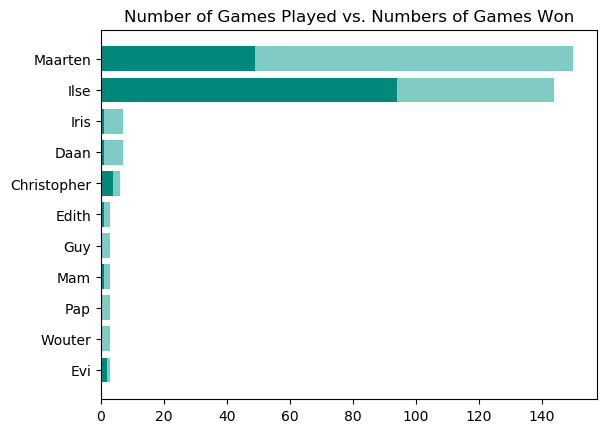

In [29]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = results_per_person.Participant
y_pos = np.arange(len(people))
won = results_per_person.Won
played = results_per_person.Played

ax.barh(y_pos, played, align='center', color='#80cbc4')
ax.barh(y_pos, won, align='center', color='#00897b')

ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('Number of Games Played vs. Numbers of Games Won')

plt.show()

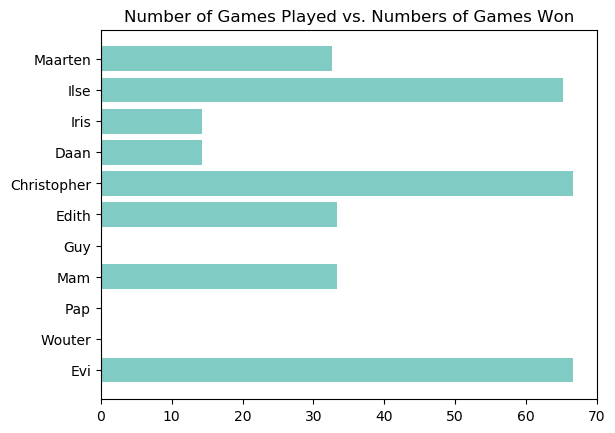

In [33]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = results_per_person.Participant
y_pos = np.arange(len(people))
percentage = results_per_person.Win_Percentage

ax.barh(y_pos, percentage, align='center', color='#80cbc4')

ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('Number of Games Played vs. Numbers of Games Won')

plt.show()

## <a name="mevsthewife">3. Me vs. The Wife</a> 
[Back to Table of Contents](#table)

#### <a name="mevsthewife-selection">3.1. Selection</a> 
[Back to Table of Contents](#table)

A selection of the data is taken showing matches between me and the wife. 

In [36]:
ilse_vs_maarten = prepare_ilse_vs_maarten(df)
ilse_vs_maarten.head(5)

,Date,Players,Game,Scores,Winner,Version,Ilse_points,Maarten_points,Ilse_won,Maarten_won,Draw,Lost
0,2018-11-18,I+M,Qwixx,I77+M77,I+M,Normal,77.0,77.0,0,0,1,0
1,2018-11-18,I+M,Qwixx,I104+M65,I,Normal,104.0,65.0,1,0,0,0
2,2018-11-18,I+M,Qwixx,I96+M62,I,Normal,96.0,62.0,1,0,0,0
3,2018-11-18,I+M,Mind,LVL10,NaN,Normal,NaN,NaN,0,0,0,1
4,2018-11-18,I+M,Mind,LVL4,NaN,Normal,NaN,NaN,0,0,0,1


#### <a name="mevsthewife-stats">3.2. Stats per Board Game</a> 
[Back to Table of Contents](#table)

In [40]:
matches = create_stats_per_board_game(ilse_vs_maarten)

In [41]:
matches.head()

Game Players Version Ilse_points                    \
                                         mean median        std   
0  7 Wonders Duel     I+M  Normal   79.000000   79.0        NaN   
1            Azul     I+M  Normal   53.714286   53.0  11.982130   
2           Claim     I+M  Normal    2.428571    2.0   0.975900   
3         Claim 2     I+M  Normal    2.000000    1.0   1.732051   
4  Codenames Duet     I+M  Normal         NaN    NaN        NaN   

  Maarten_points                   Ilse_won Maarten_won Draw Lost  
            mean median        std      sum         sum  sum  sum  
0      52.000000   52.0        NaN        1           0    0    0  
1      50.571429   55.0  14.729303        5           2    0    0  
2       2.285714    2.0   1.253566        3           3    1    0  
3       3.000000    4.0   1.732051        1           2    0    0  
4            NaN    NaN        NaN        0           0    1    1

**To prepare for D3** (not used)

In [15]:
file = [{"Name": "Ilse"}]
for row in matches.iterrows():
    file[0][row[1].Full_game] = row[1]['I_won']